In [1]:
import gc
import numpy
import pandas
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
train_data = pandas.read_csv('train_data_denoise.csv')
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64381 entries, 0 to 64380
Data columns (total 32 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Unnamed: 0                             64381 non-null  int64  
 1   PT N2 'C' Speed                        64381 non-null  float64
 2   Gear High Speed Drive End X Vibr       64381 non-null  float64
 3   Gear High Speed Drive End Y Vibr       64381 non-null  float64
 4   Gear High Speed Non-Drive End X Vibr   64381 non-null  float64
 5   Gear High Speed Non-Drive End Y Vibr   64381 non-null  float64
 6   Gear LS Shaft Axial Displ 1            64381 non-null  float64
 7   Gear LS Shaft Axial Displ 2            64381 non-null  float64
 8   Gear Low Speed Drive End X Vibr        64381 non-null  float64
 9   Gear Low Speed DriveEnd Y Vibr         64381 non-null  float64
 10  Gear Low Speed Non-Drive End X Vibr    64381 non-null  float64
 11  Ge

In [3]:
train_data.drop(['Unnamed: 0'], axis=1, inplace=True)

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >], dtype=object)

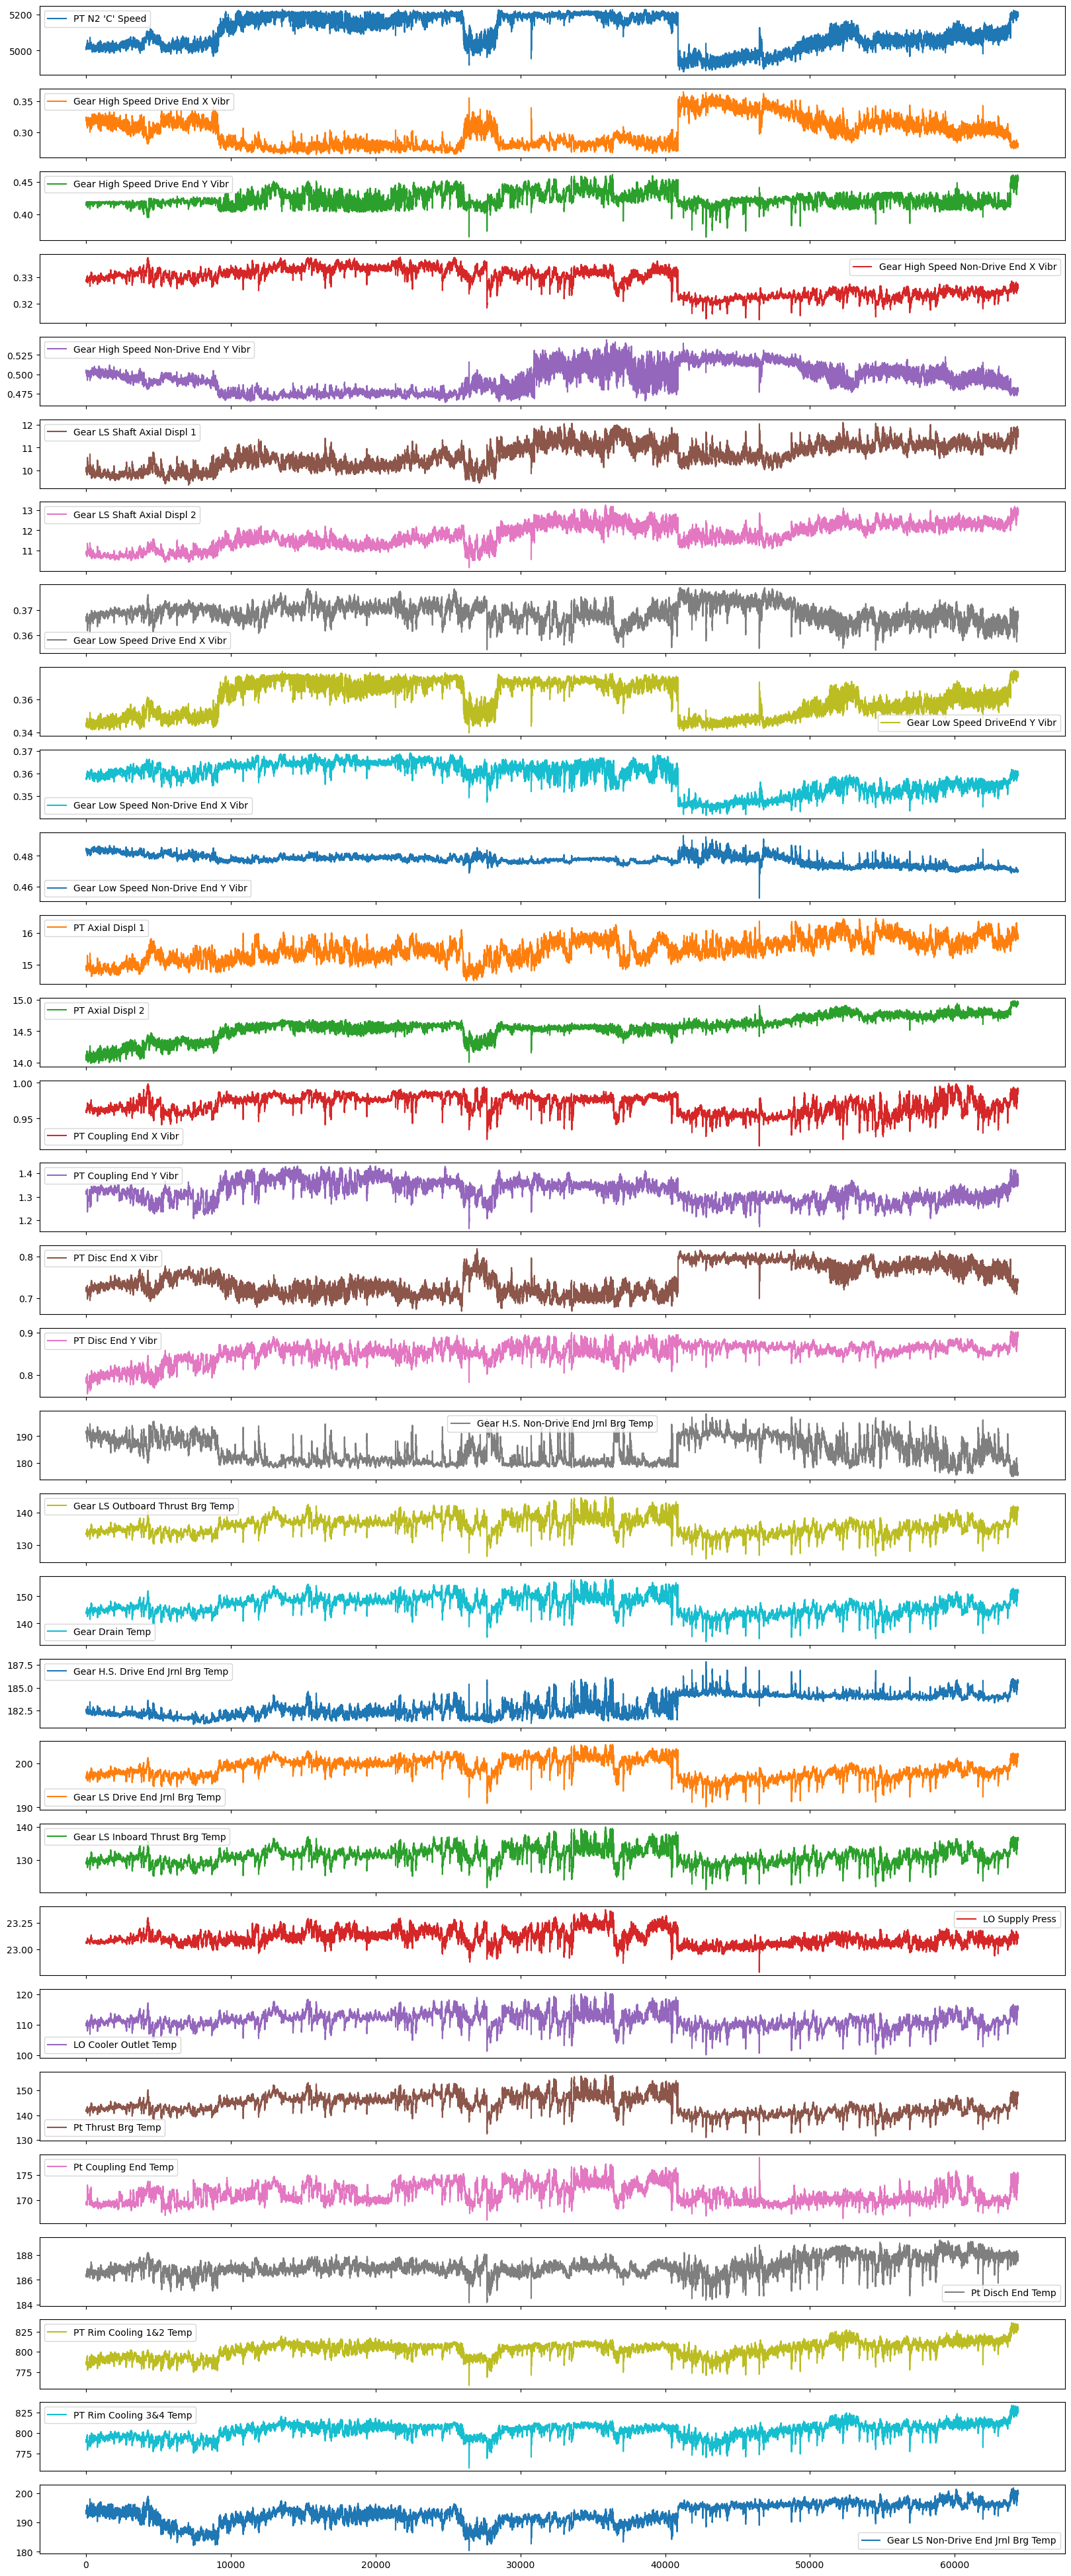

In [4]:
train_data.plot(subplots=True, figsize=(20, 50))

In [5]:
# find correlation between features
corr = train_data.corr()
corr.style.background_gradient(cmap='coolwarm')


,PT N2 'C' Speed,Gear High Speed Drive End X Vibr,Gear High Speed Drive End Y Vibr,Gear High Speed Non-Drive End X Vibr,Gear High Speed Non-Drive End Y Vibr,Gear LS Shaft Axial Displ 1,Gear LS Shaft Axial Displ 2,Gear Low Speed Drive End X Vibr,Gear Low Speed DriveEnd Y Vibr,Gear Low Speed Non-Drive End X Vibr,Gear Low Speed Non-Drive End Y Vibr,PT Axial Displ 1,PT Axial Displ 2,PT Coupling End X Vibr,PT Coupling End Y Vibr,PT Disc End X Vibr,PT Disc End Y Vibr,Gear H.S. Non-Drive End Jrnl Brg Temp,Gear LS Outboard Thrust Brg Temp,Gear Drain Temp,Gear H.S. Drive End Jrnl Brg Temp,Gear LS Drive End Jrnl Brg Temp,Gear LS Inboard Thrust Brg Temp,LO Supply Press,LO Cooler Outlet Temp,Pt Thrust Brg Temp,Pt Coupling End Temp,Pt Disch End Temp,PT Rim Cooling 1&2 Temp,PT Rim Cooling 3&4 Temp,Gear LS Non-Drive End Jrnl Brg Temp
PT N2 'C' Speed,1.000000,-0.962901,0.559006,0.699703,-0.580183,0.265571,0.318779,-0.265615,0.971900,0.792919,-0.249232,0.055406,0.136992,0.704090,0.762641,-0.839317,0.160540,-0.787594,0.726144,0.762105,-0.355816,0.866780,0.595275,0.646646,0.527153,0.780542,0.599523,0.066860,0.505760,0.566332,-0.220157
Gear High Speed Drive End X Vibr,-0.962901,1.000000,-0.472703,-0.802851,0.716657,-0.086643,-0.153540,0.146426,-0.940652,-0.865970,0.216930,0.096529,-0.058102,-0.810692,-0.803674,0.792663,-0.132613,0.852520,-0.795230,-0.841433,0.404561,-0.903498,-0.666742,-0.664910,-0.645740,-0.843161,-0.584229,-0.109262,-0.492841,-0.568972,0.202731
Gear High Speed Drive End Y Vibr,0.559006,-0.472703,1.000000,0.293953,-0.089209,0.328141,0.396513,0.096580,0.547909,0.240136,-0.203873,0.149380,0.180708,0.317075,0.366825,-0.390149,0.389469,-0.418548,0.605796,0.583179,0.101705,0.618365,0.579304,0.419373,0.508260,0.602405,0.616650,-0.071411,0.415590,0.448057,0.005957
Gear High Speed Non-Drive End X Vibr,0.699703,-0.802851,0.293953,1.000000,-0.663623,-0.455003,-0.377851,0.235205,0.621983,0.932837,0.318418,-0.457080,-0.445239,0.751536,0.705649,-0.780114,-0.200628,-0.631122,0.657894,0.757015,-0.679905,0.768518,0.522317,0.714296,0.657639,0.818723,0.511080,-0.163015,0.041879,0.155460,-0.465365
Gear High Speed Non-Drive End Y Vibr,-0.580183,0.716657,-0.089209,-0.663623,1.000000,0.317419,0.279804,0.021259,-0.573767,-0.729422,0.105094,0.307686,0.036316,-0.596376,-0.582600,0.507877,0.052066,0.537994,-0.418259,-0.499023,0.468571,-0.487433,-0.282711,-0.243356,-0.363604,-0.466176,-0.221650,-0.010469,-0.205998,-0.271703,0.211757
Gear LS Shaft Axial Displ 1,0.265571,-0.086643,0.328141,-0.455003,0.317419,1.000000,0.977362,-0.583385,0.329696,-0.323492,-0.703470,0.663662,0.693178,-0.073676,-0.085147,0.062235,0.501497,-0.158620,0.120341,0.012802,0.536540,0.103677,0.166946,-0.019226,-0.094859,-0.033243,0.210518,0.329865,0.508716,0.430253,0.311068
Gear LS Shaft Axial Displ 2,0.318779,-0.153540,0.396513,-0.377851,0.279804,0.977362,1.000000,-0.480035,0.398563,-0.263235,-0.718263,0.722942,0.756373,0.052773,-0.058113,0.054769,0.563463,-0.278246,0.248204,0.132973,0.576649,0.208949,0.299242,0.136059,0.040440,0.073954,0.335259,0.435917,0.615884,0.540968,0.380192
Gear Low Speed Drive End X Vibr,-0.265615,0.146426,0.096580,0.235205,0.021259,-0.583385,-0.480035,1.000000,-0.181943,-0.046972,0.531427,-0.281744,-0.175750,0.161402,0.070801,0.229793,0.231343,-0.025886,0.197074,0.212376,0.113303,0.079428,0.222915,0.185478,0.406979,0.241308,0.171883,-0.205440,-0.154402,-0.124369,0.113265
Gear Low Speed DriveEnd Y Vibr,0.971900,-0.940652,0.547909,0.621983,-0.573767,0.329696,0.398563,-0.181943,1.000000,0.700873,-0.322351,0.133615,0.309539,0.723406,0.785695,-0.723827,0.353697,-0.844632,0.766047,0.782167,-0.191135,0.869378,0.652558,0.619892,0.567887,0.779023,0.601151,0.125535,0.625107,0.669986,-0.071619
Gear Low Speed Non-Drive End X Vibr,0.792919,-0.865970,0.240136,0.932837,-0.729422,-0.323492,-0.263235,-0.046972,0.700873,1.000000,0.118657,-0.348421,-0.326004,0.746458,0.695648,-0.845746,-0.258363,-0.670608,0.592709,0.690855,-0.731007,0.743856,0.444437,0.654630,0.522239,0.727603

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >], dtype=object)

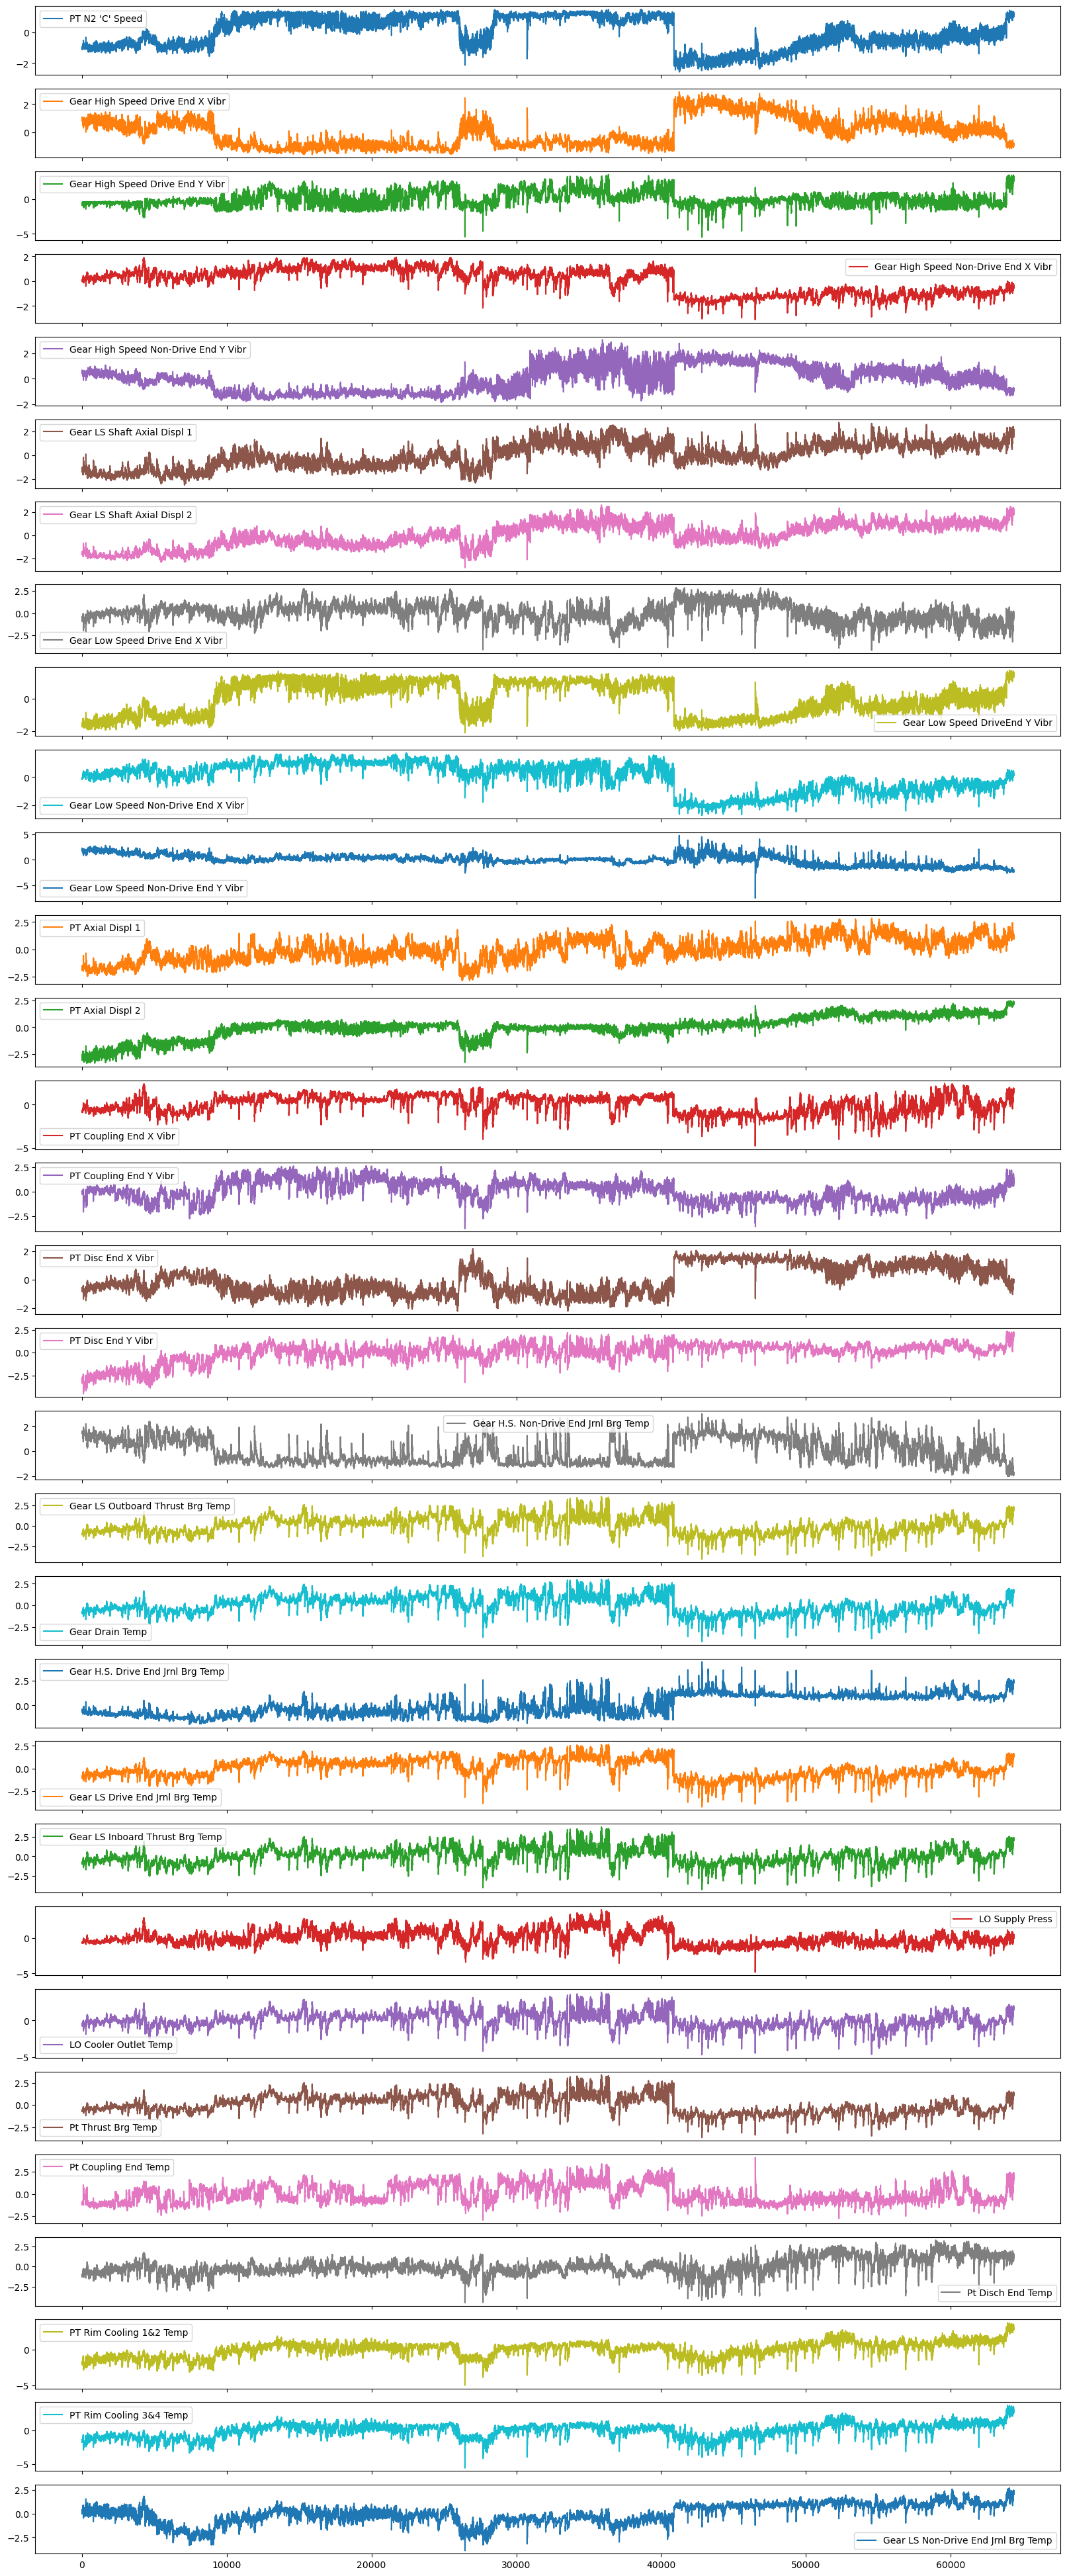

In [6]:
features = train_data.columns.to_list()

# standard scaling
from sklearn.preprocessing import StandardScaler
# create scaler for each feature
scalers = {}
for feature in features:
    scaler = StandardScaler()
    scaler.fit(train_data[feature].values.reshape(-1, 1))
    scalers[feature] = scaler

# transform data
train_data_scaled = pandas.DataFrame()
for feature in features:
    scaler = scalers[feature]
    train_data_scaled[feature] = scaler.transform(train_data[feature].values.reshape(-1, 1)).flatten()

train_data_scaled.plot(subplots=True, figsize=(20, 50))

In [7]:
# multilayer perceptron using tensorflow

def create_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(100, activation='sigmoid', input_shape=(len(features)-1,)),
        tf.keras.layers.Dense(100, activation='sigmoid'),
        tf.keras.layers.Dense(100, activation='sigmoid'),
        tf.keras.layers.Dense(1)
    ])

    model.compile(
        loss='mse',
        optimizer=tf.keras.optimizers.Adam(0.001),
        metrics=['mae', 'mse']
    )

    return model

create_model().summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               3100      
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 dense_2 (Dense)             (None, 100)               10100     
                                                                 
 dense_3 (Dense)             (None, 1)                 101       
                                                                 
Total params: 23,401
Trainable params: 23,401
Non-trainable params: 0
_________________________________________________________________


In [8]:
# create EarlyStopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    mode='min'
)

# create model for each feature, and train it
models = {}

# train with GPU
with tf.device('/GPU:0'):
    for feature in features:
        print('Training model for feature', feature)
        model = create_model()
        history = model.fit(
            train_data_scaled.drop([feature], axis=1).values,
            train_data_scaled[feature].values,
            epochs=1000,
            batch_size=32,
            validation_split=0.2,
            callbacks=[early_stopping],
            verbose=1
        )
        models[feature] = model
        model.save('models/' + feature + '.h5')
        del model

Training model for feature PT N2 'C' Speed
Epoch 1/1000
1610/1610 [==============================] - 7s 3ms/step - loss: 0.0277 - mae: 0.0579 - mse: 0.0277 - val_loss: 0.0036 - val_mae: 0.0470 - val_mse: 0.0036
Epoch 2/1000
1610/1610 [==============================] - 5s 3ms/step - loss: 4.6374e-04 - mae: 0.0159 - mse: 4.6374e-04 - val_loss: 0.0018 - val_mae: 0.0353 - val_mse: 0.0018
Epoch 3/1000
1610/1610 [==============================] - 5s 3ms/step - loss: 3.4651e-04 - mae: 0.0139 - mse: 3.4651e-04 - val_loss: 7.1650e-04 - val_mae: 0.0214 - val_mse: 7.1650e-04
Epoch 4/1000
1610/1610 [==============================] - 5s 3ms/step - loss: 2.6819e-04 - mae: 0.0123 - mse: 2.6819e-04 - val_loss: 8.3050e-04 - val_mae: 0.0245 - val_mse: 8.3050e-04
Epoch 5/1000
1610/1610 [==============================] - 5s 3ms/step - loss: 2.1485e-04 - mae: 0.0112 - mse: 2.1485e-04 - val_loss: 4.0736e-04 - val_mae: 0.0141 - val_mse: 4.0736e-04
Epoch 6/1000
1610/1610 [==============================] - 5s 